# TP3
## Grupo 15

Carlos Eduardo Da Silva Machado A96936

Gonçalo Manuel Maia de Sousa A97485

## Problema 2

### Descrição do Problema
Temos um sistema dinâmico com 4 inversores ($\,A, B, C, D\,$) que lêm um bit num canal input e escrevem num canal output uma transformação desse bit.
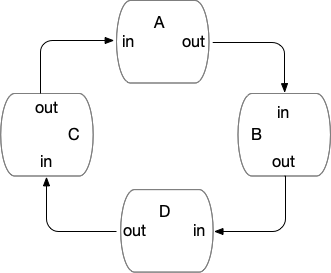

Além disso, temos de respeitar as seguintes regras:

1. Cada inversor tem um bit $s$ de estado, inicializado  com um valor aleatório.
2. Cada inversor é regido pelas transformações:
    
   
    $$\mathbf{invert}\mathtt(in,out)$$
                       $$x \gets \mathsf{read}(\mathtt{in})$$ 
                       $$s \gets \neg x\;\;\|\;\; s\gets s\oplus x  \\            
                       \mathsf{write}(\mathtt{out},s)$$
    
3. O estado do sistema é um tuplo definido pelos 4 bits $s$, e é inicializado com um vetor aleatório em $\{0,1\}^4\;$.

4. Caso o estado do sistema seja $(0,0,0,0)$, o sistema termina em ERRO.

### Abordagem do problema

Para resolver este problema, nós vamos contruir, com o auxilio do *pySMT*, um *Safe First Order Transition System* (SFOTS) definido por: $\:\:\:\Sigma\;\equiv\;\langle\,\mathsf{X}\,,\,\mathsf{next}\,,\,\mathsf{I}\,,\,\mathsf{T}\,,\,\mathsf{E}\,\rangle\:\:\:$, onde $X$ identifica as variáveis base,
next operador que gera os diversos "clones" das variáveis, $I$ determina os estados iniciais, $T$ representa a relação de transição e $E$ a condição de erros. Ao contrário dos *First Order Transitions Systems* (FOTS), o SFOTS possui a propriedade de segurança na definição do sistema.

As escolhas e o vetor aleatório que determina os valores dos bits de estado de cada um dos inversores serão gerados ao nível do input com a ajuda da bilioteca *random* do *python*, mais precisamente, com o comando random.choice.

Teremos 4 funções importantes que modelam o problema, $genState$, $init$, $trans$ e $error$ cujos objectivos são indicados juntamente do seu código *python*.

De modo a gerar um traço com $n$ estados, vamos criar a função $genTrace$ que utiliza a abordagem *bounded model checker* (BMC).
Além disso, vamos testar a segurança do sistema através de três métodos diferentes (BMC, k-indução e model checking com interpolantes) .

### Código python

Esta secção de codigo serve para importar as bibliotecas necessárias para a realização do trabalho. 

In [1]:
from pysmt.shortcuts import *
from pysmt.typing import *
import random as rn
import itertools 

Função $genState$ que tem como argumentos uma lista com as variáveis de estado $vars$, uma etiqueta (do tipo string) $s$ e um inteiro $i$. Devolve uma cópia das variáveis do estado $state$ identificadas pela etiqueta e pelo inteiro.

In [2]:
def genState(vars,s,i):
    state = {}
    for v in vars:
        state[v] = Symbol(v+'!'+s+str(i),BOOL)
    return state

Função $init$ que dado um estado do programa $state$ e uma lista de Bools $s$ que indica o valor dos 4 *bits* iniciais. Devolve um predicado do *pySMT* que testa se esse estado é um possível estado inicial do programa. Logo, para garantir que o estado é efetivamente um estado possível, temos de garantir que os valores são iguais aos gerados aleatoriamente.

In [3]:
def init(state,s):
    return And(Iff(state['A'],Bool(s[0])),Iff(state['B'],Bool(s[1])),Iff(state['C'],Bool(s[2])),Iff(state['D'],Bool(s[3])))

Função $trans$ e função auxiliar $escolha$.

A função escolha tem como argumentos $x$ que corresponde à parte $x \gets \mathsf{read}(\mathtt{in})$, pois o seu valor é o valor do *bit* do inversor que fornece o *input* para o inversor que utliza a função escolha, o $s$ é o valor do *bit* no inversor em que usamos a função $escolha$ e $first$ é um bool que determina a escolha daquele inversor na parte de código correspondente a $s \gets \neg x\;\;\|\;\; s\gets s\oplus x$. Devolve, um valor que é usado como *output*, ou seja, é escrito no próximo estado ($\mathsf{write}(\mathtt{out},s)$).

Por fim, a função de transição $trans$ com argumentos $curr$, $prox$ e $S$, onde os dois primentos indicam o estado atual e o estado seguinte, respetivamente, e o último uma lista de 4 booleanos que determinam a escolha em cada inversor. Devolve um predicado do *pySMT* que testa se é possível transitar do estado $curr$ para o estado $prox$. Os valores dos 4 *bits* são atualizados simultaneamente, ou seja, a cada transição, o tuplo terá cada um dos seus valores atualizados.

In [4]:
def escolha(x,s,first):
    return Not(x) if first else Xor(s,x)

def trans(curr,prox,S):
    tA = Iff(prox['A'],escolha(curr['C'],curr['A'],S[0]))
    tB = Iff(prox['B'],escolha(curr['A'],curr['B'],S[1]))
    tC = Iff(prox['C'],escolha(curr['D'],curr['C'],S[2]))
    tD = Iff(prox['D'],escolha(curr['B'],curr['D'],S[3]))
    
    return And(tA,tB,tC,tD)


def transUnoReverse(curr,prox,S):
    tA = Iff(prox['C'],Not(curr['A'])) if S[0] else Ite(curr['A'],Not(Iff(prox['A'],prox['C'])),Iff(prox['A'],prox['C']))
    tB = Iff(prox['A'],Not(curr['B'])) if S[1] else Ite(curr['B'],Not(Iff(prox['A'],prox['B'])),Iff(prox['A'],prox['B']))
    tC = Iff(prox['D'],Not(curr['C'])) if S[2] else Ite(curr['C'],Not(Iff(prox['D'],prox['C'])),Iff(prox['D'],prox['C']))
    tD = Iff(prox['B'],Not(curr['D'])) if S[3] else Ite(curr['D'],Not(Iff(prox['D'],prox['B'])),Iff(prox['D'],prox['B']))
    
    return And(tA,tB,tC,tD)

Função $error$ com um único argumento $state$ que indica o estado em que estamos a testar a condição de erro. Devolve um predicado do *pySMT* que testa se o estado $state$ é um possível estado de erro do programa. No caso deste problema, a condição de erro será (0,0,0,0), isto é, o *bit* de cada um dos inversores ser 0 naquele estado.

In [5]:
def error(state):
    return And(Iff(state['A'],Bool(False)),Iff(state['B'],Bool(False)),Iff(state['C'],Bool(False)),Iff(state['D'],Bool(False)))

A Função $genTrace$ gera um possível traço de execução com um número finito de transições com argumentos $vars$ (variáveis de estado), $init$ (função init acima criada), $estadoInicial$, $trans$ (função trans, também, criada acima), $S$, $error$ (função error) e $n$ que indica o número de transições.

In [6]:
def genTrace(vars,init,estadoInicial,trans,S,error,n):
    with Solver(name="z3") as s:
        
        X = [genState(vars,'X',i) for i in range(n+1)]   # cria n+1 estados (com etiqueta X)
        I = init(X[0],estadoInicial)
        Tks = [ trans(X[i],X[i+1],S) for i in range(n) ]
        
        if s.solve([I,And(Tks)]):      # testa se I /\ T^n  é satisfazível
            for i in range(n):
                print("Estado:",i)
                for v in X[i]:
                    print("          ",v,'=',s.get_value(X[i][v]))
        else:
            print("Não foi possível resolver")

In [7]:
def bmc_always(genState,init,trans,inv,K,estadoInicial,escolhas):
    for k in range(1,K+1):
        with Solver(name="z3") as s:

            trace = [genState(['A','B','C','D'],'X',i) for i in range(k)]
    
            s.add_assertion(init(trace[0],estadoInicial))
            for i in range(k-1):
                s.add_assertion(trans(trace[i], trace[i+1],escolhas))
            
            # 
            s.add_assertion(Not(inv(trace[k-1])))
            if s.solve():
                print('A propriedade não é valida')
                for i in range(k):
                    print(i)
                    print("A=", s.get_value(trace[i]['A']))
                    print("B=", s.get_value(trace[i]['B']))
                    print("C=", s.get_value(trace[i]['C']))
                    print("D=", s.get_value(trace[i]['D']))
                return
            
    print("A propriedade é válida para traços de tamanho até " + str(k))

In [8]:
def Noerror(state):
    return Or(Iff(state['A'],Bool(True)),Iff(state['B'],Bool(True)),Iff(state['C'],Bool(True)),Iff(state['D'],Bool(True)))

In [9]:
def kinduction_always(declare,init,trans,inv,k,estadoInicial,escolhas):
    with Solver(name="z3") as s:
       # criar k+1 cópias do estado
    
        traco = [genState(['A','B','C','D'],'X',i) for i in range(k+1)]
        
       #testar os k passos iniciais

        s.push()
        s.add_assertion(init(traco[0],estadoInicial))
        
        for i in range(k-1):
            s.add_assertion(trans(traco[i],traco[i+1],escolhas))
        
        s.add_assertion(Or([Not(inv(traco[i])) for i in range(k) ]))
        
        if s.solve():
            print('A propriedade não é válida nos k estados iniciais.')
            #for v in traco[0]:
                #print(v,'=',s.get_value(traco[0][v]))
            for i in range(k):
                    print(i)
                    print("A=", s.get_value(traco[i]['A']))
                    print("B=", s.get_value(traco[i]['B']))
                    print("C=", s.get_value(traco[i]['C']))
                    print("D=", s.get_value(traco[i]['D']))
            return
        
        s.pop()
        
        # testar o passo k-indutivo
        s.push()
        
        for i in range(k):
            s.add_assertion(trans(traco[i],traco[i+1],escolhas))
            s.add_assertion(inv(traco[i]))
        s.add_assertion(Not(inv(traco[k])))
        
        if s.solve():
            print('O passo %s indutivo nao preserva a propriedade.' % k)
            print("O ponto onde falha começa aqui:")
            for v in traco[0]:
                print(v,'=',s.get_value(traco[0][v]))
            return
        
        print("A propriedade é sempre válida")
        s.pop()

Funções $baseName$, $rename$, $same$ e $invert$ definidas na ficha9, a primeira é fornece o nome da variável, a segunda com o aulixio da primeira renomeia uma fórmula de acordo com um dado estado, a penúltima verifica se dois estados são iguais e a última é uma função de ordem superior que recebe a função de transição e devolve a sua inversa.

In [10]:
def baseName(s):
    return ''.join(list(itertools.takewhile(lambda x: x!='!', s)))

def rename(form,state):
    vs = get_free_variables(form)
    pairs = [ (x,state[baseName(x.symbol_name())]) for x in vs ] # Descobrir os pares # symbol_name dá o nome aka string da var
    return form.substitute(dict(pairs)) # recebe um dicionário e substitui as chaves do dicionário pelo o que está no value

def same(state1,state2): # ver se as duas vars têm o mesmo valor
    return And([Iff(state1[x],state2[x]) for x in state1])

def invert(trans,S):
    return (lambda u, v: trans(v,u,[not elem for elem in S]))

Função $model-checking$ de ordem superior da ficha 9 que dada a lista de nomes das variáveis do sistema $vars$ , um predicado que testa se um estado é inicial $init$, um predicado que testa se um par de estados é uma transição válida $trans$ , um predicado que testa se um estado é de erro $error$, dois números positivos $N$ e $M$ que são os limites máximos para os indices n e m, uma lista de *bools* com que indica os valores dos *bits* no estado inicial e outra lista com elementos do mesmo tipo que indica cada a escolha de cada um dos 4 inversores. O seu objetivo é implementar o algoritmo de "model-checking" com o auxílio do *SMT* *solver* e o algoritmo para encontrar o majorante S descrito na ficha.

In [11]:
def model_checking(vars,init,trans,error,N,M,estadoInicial,escolhas):
    with Solver(name="z3") as s:
        
        # Criar todos os estados que poderão vir a ser necessários.
        X = [genState(vars,'X',i) for i in range(N+1)] # Com a função genState, criar todos os estados que possam ser necessário, TODOS. # X SFOTS original
        Y = [genState(vars,'Y',i) for i in range(M+1)] # Y SFOTS invertido

        # Estabelecer a ordem pela qual os pares (n,m) vão surgir. Por exemplo:
        order = sorted([(a,b) for a in range(1,N+1) for b in range(1,M+1)],key=lambda tup:tup[0]+tup[1]) # Estabelecer ordem que criamos o n e o m # ideia da stora: usar o sorted,
                                                                                                         # gerar todos os pares possíveis 
                                                                                                         # e ter como critério de ordenação as soma dos elementos dos pares
        
        for (n,m) in order: # Seguir o algoritmo
            # completar
            I = init(X[0],estadoInicial) # o X é uma lista de estados
            Tn = And([trans(X[i],X[i+1],escolhas) for i in range(n)])
            Rn = And(I,Tn) # estados acessíveis em n transições
            
            E = error(Y[0])
            Bm = And([transUnoReverse(Y[i],Y[i+1],escolhas) for i in range(m)])
            Um = And(E,Bm) # estados inseguros em m transições
            
            Vnm = And(Rn,same(X[n],Y[m]),Um) # temos de testar se dois estados estão iguais e, portanto, usamos a função same dada acima
            
            if s.solve([Vnm]):
                print("unsafe")
                return 
           
            # Se for insatisfazível, temos de criar o interpolante para n fórmulas
            C = binary_interpolant(And(Rn,same(X[n],Y[m])), Um)
            if C is None:
                print("Interpolante None")
                continue
            
            C0 = rename(C,X[0]) # Rename do C com o estado envolvido, neste caso o X[0] 
            C1 = rename(C,X[1])
            # Trabalhamos com X[0] e X[1] porque T pode ser escrito como T = (X0,X1)
            
            T = trans(X[0],X[1],escolhas)
            
            if not s.solve([C0,T,Not(C1)]):
                print("Safe")
                return
            else:
                    #### gerar o S (Parte que descreve o Majorante S)
                
                #Passo 1:
                S = rename(C,X[n])
                while True:
                    #Passo 2:
                    A = And(S,trans(X[n],Y[m],escolhas))
                    if s.solve([A,Um]):
                        print("Não foi possível encontrar o majorante.")
                        break
                    else:
                        CNew = binary_interpolant(A,Um) # as duas formulas têm de ser inconsistentes para que faça sentido para usar binary_interpolant
                        Cn = rename(CNew,X[n])
                        
                        if s.solve([Cn,Not(S)]):
                            S = Or(S,Cn)
                        else:
                            print("Safe")
                            return
            
        print("unknown")  

### Exemplos e Testes de Aplicação

#### Exemplo 1

In [12]:
estadoInicial = [rn.choice([True,False]) for i in range(4)]
print(f"Estado inicial: {tuple(estadoInicial)}")

#escolhas = [rn.choice([True,False]) for i in range(4)]
escolhas = [True,True,True,True]
print(f"Escolhas: {tuple(escolhas)}")
print()
n_trasicoes = 10
print(f"Traço de {n_trasicoes} transições:")
genTrace(['A','B','C','D'],init,estadoInicial,trans,escolhas,error,n_trasicoes)
print()
print("Verificação BMC do sistema:")
bmc_always(genState,init,trans,Noerror,10,estadoInicial,escolhas)
print()
print("Verificação com k-indução do sistema:")
kinduction_always(genState,init,trans,Noerror,4,estadoInicial,escolhas)
print()
print("Verificação model checking com interpolantes do sistema:")
model_checking(['A','B','C','D'], init,trans, error, 50, 50,estadoInicial,escolhas)

Estado inicial: (False, False, True, True)
Escolhas: (True, True, True, True)

Traço de 10 transições:
Estado: 0
           A = False
           B = False
           C = True
           D = True
Estado: 1
           A = False
           B = True
           C = False
           D = True
Estado: 2
           A = True
           B = True
           C = False
           D = False
Estado: 3
           A = True
           B = False
           C = True
           D = False
Estado: 4
           A = False
           B = False
           C = True
           D = True
Estado: 5
           A = False
           B = True
           C = False
           D = True
Estado: 6
           A = True
           B = True
           C = False
           D = False
Estado: 7
           A = True
           B = False
           C = True
           D = False
Estado: 8
           A = False
           B = False
           C = True
           D = True
Estado: 9
           A = False
           B = True
           C = Fal

#### Exemplo 2

In [13]:
estadoInicial = [rn.choice([True,False]) for i in range(4)]
print(f"Estado inicial: {tuple(estadoInicial)}")

escolhas = [rn.choice([True,False]) for i in range(4)]
print(f"Escolhas: {tuple(escolhas)}")
print()
n_trasicoes = 10
print(f"Traço de {n_trasicoes} transições:")
genTrace(['A','B','C','D'],init,estadoInicial,trans,escolhas,error,n_trasicoes)
print()
print("Verificação BMC do sistema:")
bmc_always(genState,init,trans,error,80,estadoInicial,escolhas)
print()
print("Verificação com k-indução do sistema:")
kinduction_always(genState,init,trans,Noerror,4,estadoInicial,escolhas)
print()
print("Verificação model checking com interpolantes do sistema:")
model_checking(['A','B','C','D'], init,trans, error, 50, 50,[True, False, False, False],[True, False, False, True])

# weird
#Estado inicial: (True, False, False, False)
#Escolhas: (True, False, False, True)

Estado inicial: (True, False, True, False)
Escolhas: (False, False, False, True)

Traço de 10 transições:
Estado: 0
           A = True
           B = False
           C = True
           D = False
Estado: 1
           A = False
           B = True
           C = True
           D = True
Estado: 2
           A = True
           B = True
           C = False
           D = False
Estado: 3
           A = True
           B = False
           C = False
           D = False
Estado: 4
           A = True
           B = True
           C = False
           D = True
Estado: 5
           A = True
           B = False
           C = True
           D = False
Estado: 6
           A = False
           B = True
           C = True
           D = True
Estado: 7
           A = True
           B = True
           C = False
           D = False
Estado: 8
           A = True
           B = False
           C = False
           D = False
Estado: 9
           A = True
           B = True
           C = Fa

#### Exemplo 3

In [14]:
estadoInicial2 = [rn.choice([True,False]) for i in range(4)]
print(f"Estado inicial: {tuple(estadoInicial)}")
escolhas2 = [rn.choice([True,False]) for i in range(4)]
print(f"Escolhas: {tuple(escolhas)}")
print()
n_trasicoes = 10
print(f"Traço de {n_trasicoes} transições:")
genTrace(['A','B','C','D'],init,estadoInicial,trans,escolhas,error,n_trasicoes)
print()
print("Verificação BMC do sistema:")
bmc_always(genState,init,trans,error,80,estadoInicial,escolhas)
print()
print("Verificação com k-indução do sistema:")
kinduction_always(genState,init,trans,Noerror,4,estadoInicial,escolhas)
print()
print("Verificação model checking com interpolantes do sistema:")
model_checking(['A','B','C','D'], init,trans, error, 50, 50,estadoInicial2,escolhas2)

Estado inicial: (True, False, True, False)
Escolhas: (False, False, False, True)

Traço de 10 transições:
Estado: 0
           A = True
           B = False
           C = True
           D = False
Estado: 1
           A = False
           B = True
           C = True
           D = True
Estado: 2
           A = True
           B = True
           C = False
           D = False
Estado: 3
           A = True
           B = False
           C = False
           D = False
Estado: 4
           A = True
           B = True
           C = False
           D = True
Estado: 5
           A = True
           B = False
           C = True
           D = False
Estado: 6
           A = False
           B = True
           C = True
           D = True
Estado: 7
           A = True
           B = True
           C = False
           D = False
Estado: 8
           A = True
           B = False
           C = False
           D = False
Estado: 9
           A = True
           B = True
           C = Fa

KeyboardInterrupt: 

#### Exemplo 4

In [ ]:
estadoInicial4 = [rn.choice([True,False]) for i in range(4)]
print(f"Estado inicial: {tuple(estadoInicial)}")

escolhas4 = [rn.choice([True,False]) for i in range(4)]
print(f"Escolhas: {tuple(escolhas)}")
print()
n_trasicoes = 10
print(f"Traço de {n_trasicoes} transições:")
genTrace(['A','B','C','D'],init,estadoInicial,trans,escolhas,error,n_trasicoes)
print()
print("Verificação BMC do sistema:")
bmc_always(genState,init,trans,error,80,estadoInicial,escolhas)
print()
print("Verificação com k-indução do sistema:")
kinduction_always(genState,init,trans,Noerror,4,estadoInicial,escolhas)
print()
print("Verificação model checking com interpolantes do sistema:")
model_checking(['A','B','C','D'], init,trans, error, 50, 50,estadoInicial4,escolhas4)

#### Exemplo 5

In [ ]:
estadoInicial = [rn.choice([True,False]) for i in range(4)]
print(f"Estado inicial: {tuple(estadoInicial)}")

escolhas = [rn.choice([True,False]) for i in range(4)]
print(f"Escolhas: {tuple(escolhas)}")
print()
n_trasicoes = 10
print(f"Traço de {n_trasicoes} transições:")
genTrace(['A','B','C','D'],init,estadoInicial,trans,escolhas,error,n_trasicoes)
print()
print("Verificação BMC do sistema:")
bmc_always(genState,init,trans,error,80,estadoInicial,escolhas)
print()
print("Verificação com k-indução do sistema:")
kinduction_always(genState,init,trans,Noerror,4,estadoInicial,escolhas)
print()
print("Verificação model checking com interpolantes do sistema:")
model_checking(['A','B','C','D'], init,trans, error, 50, 50,estadoInicial,escolhas)